<function matplotlib.pyplot.show(close=None, block=None)>

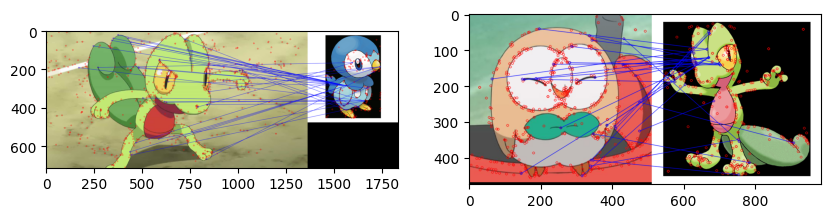

In [2]:
import os
import matplotlib.pyplot as plt
import cv2
import numpy as np

PATH = './Images/Data/'
target1 = './Images/Object.png'
target2 = './Images/Object2.png'

def load_process(path):
    img = cv2.imread(path)

    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_gray = cv2.equalizeHist(img_gray)
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB), img_gray

object1, object1_gray = load_process(target1)
object2, object2_gray = load_process(target2)

object1_gray = cv2.medianBlur(object1_gray, 5)
object2_gray = cv2.GaussianBlur(object2_gray, (3,3), 0)

sift = cv2.SIFT.create()

obj1_kp, obj1_desc = sift.detectAndCompute(object1_gray, None)
obj2_kp, obj2_desc = sift.detectAndCompute(object2_gray, None)

def feature_matching(desc, target_desc):
    flann = cv2.FlannBasedMatcher(dict(algorithm=1), dict(checks=50))
    matches = flann.knnMatch(np.float32(target_desc), desc, k=2)
    matches_mask = [[0,0] for _ in range(len(matches))]

    curr_match = 0
    for i, (fm, sm) in enumerate(matches):
        if fm.distance < 0.7 * sm.distance:
            curr_match += 1
            matches_mask[i] = [1,0]

    return matches, matches_mask, curr_match

best1 = 0
best2 = 0
best1_data = None
best2_data = None

for file in os.listdir(PATH):
    img, img_gray = load_process(PATH + file)

    img1_gray = cv2.medianBlur(img_gray, 5)
    img2_gray = cv2.GaussianBlur(img_gray, (3,3), 0)

    img1_kp, img1_desc = sift.detectAndCompute(img1_gray, None)
    img2_kp, img2_desc = sift.detectAndCompute(img2_gray, None)

    matches1, matches_mask1, curr_match1 = feature_matching(img1_desc, obj1_desc)
    matches2, matches_mask2, curr_match2 = feature_matching(img2_desc, obj2_desc)

    if curr_match1 > best1:
        best1 = curr_match1
        best1_data = {
            "img" : img,
            "keypoint" : img1_kp,
            "matches" : matches1,
            "mask" : matches_mask1
        }
    if curr_match2 > best2:
        best2 = curr_match2
        best2_data = {
            "img" : img,
            "keypoint" : img2_kp,
            "matches" : matches2,
            "mask" : matches_mask2
        }

plt.figure(figsize=(10,8))
plt.subplot(1,2,1)
result = cv2.drawMatchesKnn(object1,
                            obj1_kp,
                            best1_data["img"],
                            best1_data["keypoint"],
                            best1_data["matches"],
                            None,
                            matchColor=[0,0,255],
                            singlePointColor=[255,0,0],
                            matchesMask=best1_data["mask"]
)
plt.imshow(result)

plt.subplot(1,2,2)
result = cv2.drawMatchesKnn(object2,
                            obj2_kp,
                            best2_data["img"],
                            best2_data["keypoint"],
                            best2_data["matches"],
                            None,
                            matchColor=[0,0,255],
                            singlePointColor=[255,0,0],
                            matchesMask=best2_data["mask"]
)
plt.imshow(result)
plt.show